In [1]:
import numpy as np
import pandas as pd
import time
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
import joblib
import json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib
import os

%load_ext autoreload
%autoreload 2
%matplotlib notebook
# %matplotlib inline

In [2]:
# body_part = "head"
# file_names = ['./training_data/head_data_1.log',
#              './training_data/head_data_2.log',
#              './training_data/head_data_3.log',
#              './training_data/head_data_4.log',
#              './training_data/head_data_5.log',
#              './training_data/head_data_6.log']

# body_part = "shoulder_right"
# file_names = [
#              './training_data_old/shoulder_right_data_1.log',
#              './training_data_old/shoulder_right_data_2.log',
#              './training_data_old/shoulder_right_data_3.log',
#              './training_data_old/shoulder_right_data_4.log',
#              './training_data_old/shoulder_right_data_5.log']

# body_part = "shoulder_right"
# file_names = [
#              './training_data/shoulder_right_train_10_17.log',
#              './training_data_old/shoulder_right_data_6.log',
#              './training_data_old/shoulder_right_data_7.log',
#              './training_data_old/shoulder_right_data_8.log',
#              './training_data_old/shoulder_right_data_9.log',
#             ]

body_part = "shoulder_left"
file_names = [
    './training_data/val_fb_sfast_dvbf_medium.bag'
#     './training_data/val_fb_fast_gt.csv'
]

# file_names = ['./training_data/shoulder_left_5.log',
#               './training_data/shoulder_left_6.log',
#               './training_data/shoulder_left_7.log']

# body_part = "shoulder_left"
# file_names = ['./training_data/shoulder_left_1.log',
#               './training_data/shoulder_left_2.log',
#               './training_data/shoulder_left_3.log']

In [3]:
abnormal_threshold = 0.5
dataset = []
orig_dataset = []

euler_idxs = ["position_0", "position_1", "position_2"]
# action_idxs = ["cf_velocity_0", "cf_velocity_1", "cf_velocity_2"]
action_idxs = ["target_position_0", "target_position_1", "target_position_2"]
magnetic_idxs = [f'{coord}_{id}' for id in range(4) for coord in ['x','y','z']]

for name in file_names:
    df = pd.read_csv(name, header=0)
    
#     df['date'] = pd.to_datetime(df.Time, unit='s')
#     df.groupby(pd.Grouper(key='date', freq='20L')).mean().interpolate()

    orig_dataset.append(df.copy())
    
    # interpolate nan outputs (loss tracking)
    for c in euler_idxs:
        df[c] = df[c].interpolate()
    
    # interpolate abnormal inputs
#     for c in magnetic_idxs:
#         bad_idx = df.index[df[c].pct_change().abs().ge(abnormal_threshold)]
#         df.loc[bad_idx, c] = np.nan
#         df[c] = df[c].interpolate()
    
#     # Add action
#     for c in df.columns[-3:]:
#         df["dt"] = (df["Time"][1:].tolist() - df["Time"][:-1])
#         df[c + "_u"] = (df[c][1:].tolist() - df[c][:-1]) / df["dt"]
    
#     # Remove last row
#     df = df[:-1]
    dataset.append(df)

dataset_len = [len(data) for data in dataset]
dataset = pd.concat(dataset) 
orig_dataset = pd.concat(orig_dataset)

print(f'{np.sum(dataset_len)} values')

dataset = dataset[["Time"] + magnetic_idxs + euler_idxs + action_idxs].values[:,1:]
orig_dataset = orig_dataset[["Time"] + magnetic_idxs + euler_idxs + action_idxs].values[:,1:]

# dataset = dataset[abs(dataset[:,12])!=0.0,:]
# dataset = dataset[abs(dataset[:,13])!=0.0,:]
# dataset = dataset[abs(dataset[:,14])!=0.0,:]

# print(f'{len(dataset)} values after filtering outliers')

euler_set = dataset[:, 12:15]
action_set = dataset[:, 15:]
sensors_set = dataset[:, :12]
orig_sensors_set = orig_dataset[:, :12]
print(f'max euler {str(np.amax(euler_set))}')
print(f'min euler {str(np.amin(euler_set))}')

24010 values
max euler 3.135378403228545
min euler -3.1407292575036365


In [4]:
len(orig_dataset), len(dataset)

(24010, 24010)

In [5]:
dataset_len

[24010]

In [6]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from libs.orientation_utils import compute_rotation_matrix_from_euler, compute_ortho6d_from_rotation_matrix, compute_rotation_matrix_from_ortho6d, compute_euler_angles_from_rotation_matrices

In [7]:
euler_set_in = np.zeros_like(euler_set)
euler_set_in[:, 0] = euler_set[:, 2] 
euler_set_in[:, 1] = euler_set[:, 1] 
euler_set_in[:, 2] = euler_set[:, 0] 

euler_set = torch.Tensor(euler_set_in).cuda()
rot_set = compute_rotation_matrix_from_euler(euler_set)
rot_set = compute_ortho6d_from_rotation_matrix(rot_set).cpu().detach().numpy()

In [8]:
# model_path = f"./outputs_idp/local_{body_part}_dvbf_long_trajs_ad_with_target_rot6D"
model_path = f"./outputs_idp_isrr/{body_part}_dvbf_long_trajs_no_ad_with_target_rot6D"

sensors_scaler, action_scaler = joblib.load(f'{model_path}/scaler.pkl')

# Split magnetic sensors into 4 independent distributions again
orig_sensors_set = sensors_scaler.transform(orig_sensors_set).reshape(-1, 4, 3)
sensors_set = sensors_scaler.transform(sensors_set).reshape(-1, 4, 3)
action_set = action_scaler.transform(action_set)

In [9]:
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers.csv_logs import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from libs.data_modules import SensorsDataModule
from libs.nn_models import mse_seq
from libs.dvbf_models import DVBF

In [10]:
look_back = 10

data_in = []
data_u = []
data_hat_in = []
data_out = []

start_idx = 0
for l in dataset_len:
    # Ignore the last batch
    for i in range(start_idx, start_idx+l-look_back*2):
        data_in.append(orig_sensors_set[i:i+look_back])
        data_hat_in.append(sensors_set[i:i+look_back])
        data_u.append(action_set[i:i+look_back])
        data_out.append(rot_set[i+1:i+look_back+1])
    print(len(data_in))
    start_idx += l

23990


In [11]:
with open(f'{model_path}/hyperparams.json', 'r') as fp:
    p = json.load(fp)

In [12]:

dm = SensorsDataModule(
    data_x = data_in,
#     data_x = data_hat_in,
    data_u = data_u,
    data_y = data_out,
    data_x_hat = data_hat_in,
    seq_len = p['seq_len'],
    batch_size = p['batch_size']
)

In [13]:
# model = DVBF.load_from_checkpoint(checkpoint_path=f"{model_path}/best-epoch=9889-val_loss=-233.49173.ckpt")
model = DVBF.load_from_checkpoint(checkpoint_path=f"{model_path}/best-alpha=30.0-reg=0.01.ckpt")

/home/thobotics/anaconda3/envs/tum/lib/python3.6/site-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [14]:
# device = "cuda"
device = "cpu"
model.to(device)
torch.set_grad_enabled(False)
model.eval()

DVBF(
  (initial_lstm): LSTM(12, 100, batch_first=True, dropout=0.1, bidirectional=True)
  (initial_to_params): Sequential(
    (0): Linear(in_features=200, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=64, bias=True)
  )
  (w1_to_z1): Sequential(
    (0): Linear(in_features=32, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=32, bias=True)
  )
  (matrix_params): Sequential(
    (0): Linear(in_features=35, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=16, bias=True)
    (3): Softmax(dim=1)
  )
  (decoder_model): Sequential(
    (0): Linear(in_features=32, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=24, bias=True)
  )
  (regressor_model): Sequential(
    (0): Linear(in_features=32, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=12, bias=True)
  )
  (encoder_models): 

In [15]:
sen_in = orig_sensors_set[None]
in_set = torch.tensor(sen_in, dtype=torch.float32).to(device)
u_set = torch.tensor(action_set[None], dtype=torch.float32).to(device)
# u_set *= 0.0
out_set, meas_mean_set, meas_var_set = model.predict(in_set, u_set, True)
out_set = out_set[0]
rot_pred = compute_rotation_matrix_from_ortho6d(out_set)

In [16]:
test_euler_set = dataset[:, 12:15]
time_arr = np.arange(len(test_euler_set))#[9500:11000]#[6500:7500]
plt_prefix = "ts_9k5-11k"

euler_pred = compute_euler_angles_from_rotation_matrices(rot_pred).cpu().detach().numpy()[time_arr]
euler_gt = torch.tensor(test_euler_set, dtype=torch.float32).to(device).cpu().detach().numpy()[time_arr]

In [17]:
plt.rc('font', size=18)

<IPython.core.display.Javascript object>


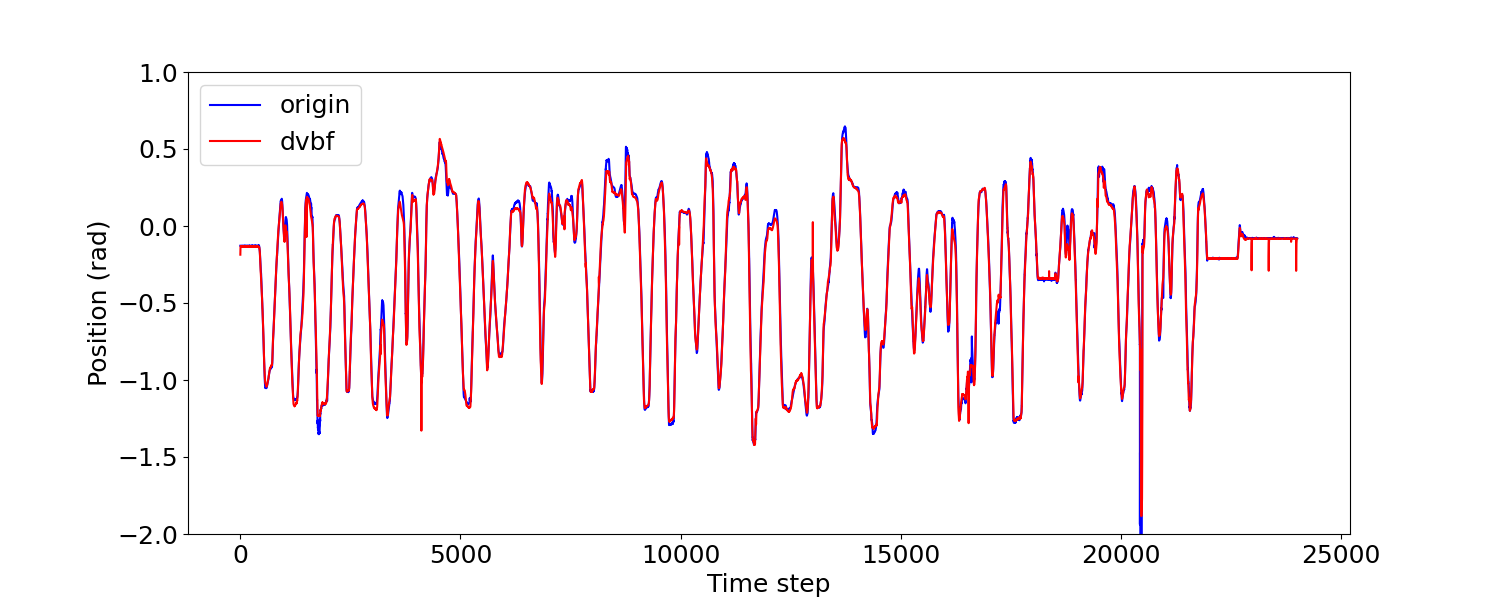

In [32]:
fig = plt.figure(figsize=(15,6))
plt.plot(time_arr, euler_gt[:, 0], c="blue", label="origin")
plt.plot(time_arr, euler_pred[:, 0], c="red", label="dvbf")
plt.legend(loc="upper left")
plt.xlabel("Time step")
plt.ylabel("Position (rad)")
plt.ylim(ymax = 1.0, ymin = -2.0)
plt.show()
# fig.savefig(f'{model_path}/{plt_prefix}_dvbf_euler_0.pdf', dpi=100, bbox_inches='tight')

<IPython.core.display.Javascript object>


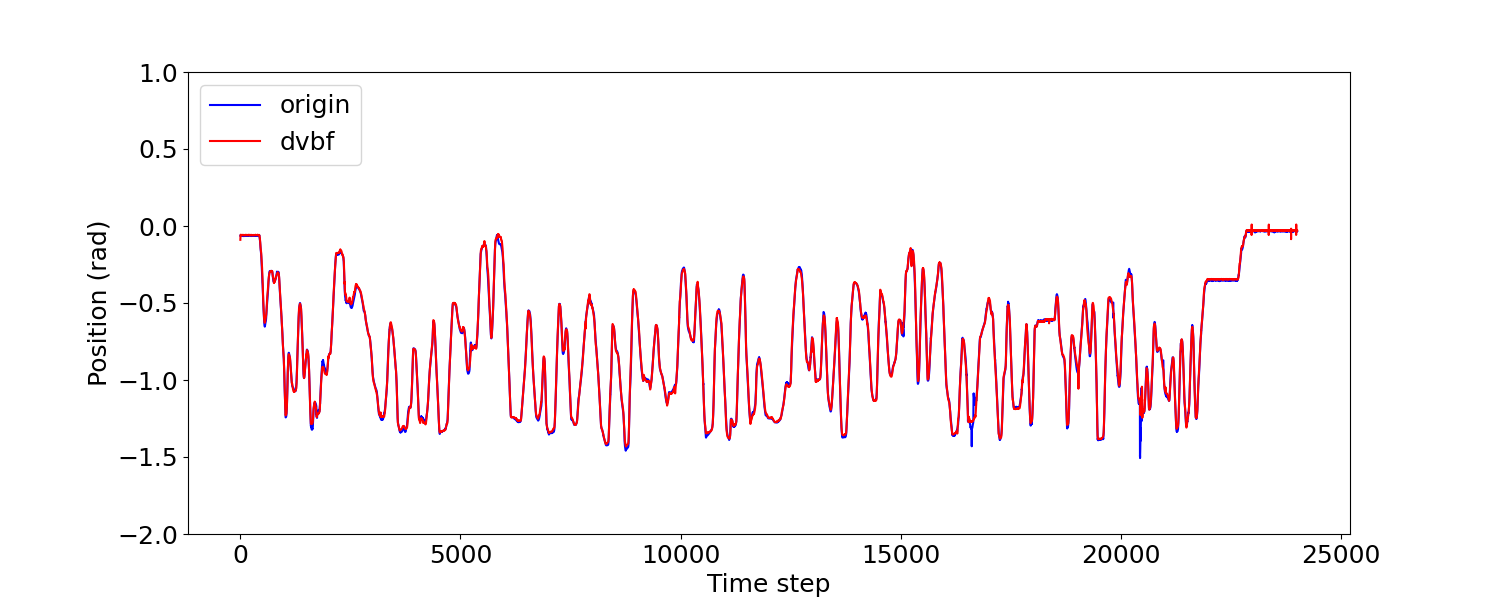

In [33]:
fig = plt.figure(figsize=(15,6))
plt.plot(time_arr, euler_gt[:, 1], c="blue", label="origin")
plt.plot(time_arr, euler_pred[:, 1], c="red", label="dvbf")
plt.legend(loc="upper left")
plt.xlabel("Time step")
plt.ylabel("Position (rad)")
plt.ylim(ymax = 1.0, ymin = -2.0)
plt.show()
# fig.savefig(f'{model_path}/{plt_prefix}_dvbf_euler_1.pdf', dpi=100, bbox_inches='tight')

<IPython.core.display.Javascript object>


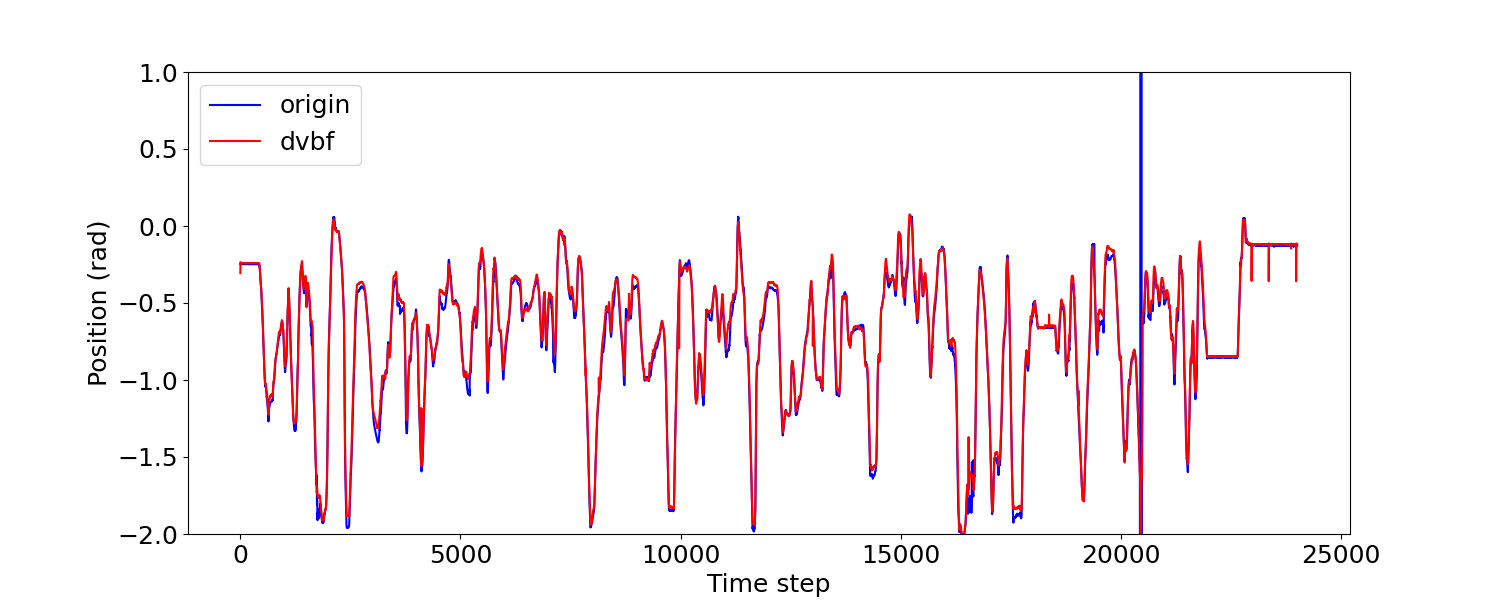

In [34]:
fig = plt.figure(figsize=(15,6))
plt.plot(time_arr, euler_gt[:, 2], c="blue", label="origin")
plt.plot(time_arr, euler_pred[:, 2], c="red", label="dvbf")
plt.legend(loc="upper left")
plt.xlabel("Time step")
plt.ylabel("Position (rad)")
plt.ylim(ymax = 1.0, ymin = -2.0)
plt.show()
# fig.savefig(f'{model_path}/{plt_prefix}_dvbf_euler_2.pdf', dpi=100, bbox_inches='tight')

# Analysis at jumpy area

In [21]:
np.set_printoptions(precision=5, suppress=True)

## Timestep 7k

In [22]:
mag = sen_in[0, :, 1][time_arr]
mag[7020:7025, :]

array([[ 0.13023, -0.06818, -0.08066],
       [ 0.12929, -0.06629, -0.08066],
       [ 0.13117, -0.06629, -0.08066],
       [ 0.13023, -0.06629, -0.08185],
       [ 0.13117, -0.06439, -0.08066]])

In [23]:
torch.stack(meas_mean_set[7020:7025], dim=0).detach().numpy().shape

(5, 1, 4, 32)

In [24]:
torch.stack(meas_mean_set[7020:7025], dim=0).detach().numpy()[:, 0, 1]

array([[ 0.39152,  0.20442,  0.50238, -0.18826, -0.08425, -0.02608,
         0.36544,  0.36901,  2.61229, -0.00587,  0.09485, -0.44984,
        -0.11898,  0.60676, -0.67916,  0.19475,  0.09076,  0.48431,
        -0.02618, -0.11128,  0.05395,  0.47733, -0.23547,  0.35785,
        -0.23622,  0.55185, -1.15245, -0.42494,  1.95493, -0.08135,
        -0.55927,  0.31136],
       [ 0.39   ,  0.20425,  0.50362, -0.18778, -0.08683, -0.02612,
         0.36671,  0.36859,  2.60989, -0.00599,  0.09462, -0.44849,
        -0.11867,  0.603  , -0.67592,  0.1959 ,  0.09232,  0.48323,
        -0.02705, -0.11222,  0.05333,  0.47998, -0.23463,  0.35718,
        -0.23605,  0.54762, -1.15595, -0.42459,  1.95468, -0.08163,
        -0.55476,  0.3082 ],
       [ 0.38706,  0.20268,  0.49942, -0.18694, -0.07811, -0.02617,
         0.3674 ,  0.36907,  2.6155 , -0.00703,  0.09658, -0.44876,
        -0.11942,  0.60553, -0.67711,  0.19824,  0.09283,  0.48036,
        -0.03081, -0.11145,  0.05237,  0.47564, -0.23441, 

In [25]:
1/torch.stack(meas_var_set[7020:7025], dim=0).detach().numpy()[:, 0, 1].sum(axis=1)

array([0.59885, 0.60012, 0.59989, 0.59953, 0.60104], dtype=float32)

In [26]:
1/torch.stack(meas_var_set[7020:7025], dim=0).detach().numpy()[0, 0, :].sum(axis=1)

array([1.39837, 0.59885, 0.16365, 0.28063], dtype=float32)

## TImestep 10k

In [27]:
# idxs = slice(10309, 10314)
idxs = slice(10847, 10860)
# idxs = slice(11580, 11590)

In [28]:
mag = sen_in[0, :, 2]
mag[idxs, :]

array([[-0.22877,  0.25828,  0.29216],
       [-0.22953,  0.26159,  0.28845],
       [-0.23259,  0.2649 ,  0.28598],
       [-0.23336,  0.26987,  0.28227],
       [-0.23489,  0.27318,  0.2761 ],
       [-0.23642,  0.27815,  0.27116],
       [-0.23718,  0.28311,  0.26621],
       [-0.23948,  0.28477,  0.26374],
       [-0.24024,  0.28808,  0.2588 ],
       [-0.24024,  0.29305,  0.25633],
       [-0.24254,  0.2947 ,  0.25015],
       [-0.24331,  0.29801,  0.24892],
       [-0.24331,  0.29967,  0.24521]])

In [29]:
torch.stack(meas_mean_set[idxs], dim=0).detach().numpy()[:, 0, 2]

array([[ 0.83293,  0.33247,  0.06795, -0.15547, -0.23172,  0.11575,
         0.0656 ,  0.19164,  0.27202,  0.04875,  0.18878, -2.00506,
        -1.04587,  0.49013, -1.52898, -0.808  ,  0.01052,  0.26917,
         1.46789,  0.93315,  0.65057, -0.06808, -0.39005,  2.68195,
         1.03551,  0.23311, -0.69747,  0.02653, -0.19621, -2.97109,
         0.01827, -1.18293],
       [ 0.82286,  0.32542,  0.06814, -0.16148, -0.22988,  0.10301,
         0.0641 ,  0.18492,  0.27793,  0.05076,  0.19253, -2.00988,
        -1.04303,  0.48388, -1.54285, -0.80731,  0.00824,  0.2586 ,
         1.46   ,  0.93226,  0.65241, -0.0628 , -0.38427,  2.67396,
         1.03291,  0.25071, -0.69199,  0.02627, -0.19881, -2.98142,
         0.01868, -1.19717],
       [ 0.8137 ,  0.3229 ,  0.0674 , -0.17018, -0.22986,  0.09069,
         0.06087,  0.18177,  0.28232,  0.0557 ,  0.19412, -2.01439,
        -1.04061,  0.47904, -1.55563, -0.80937,  0.0045 ,  0.2505 ,
         1.45543,  0.9336 ,  0.6547 , -0.05382, -0.378  , 

In [30]:
1/torch.stack(meas_var_set[idxs], dim=0).detach().numpy()[:, 0, 2].sum(axis=1)

array([0.18537, 0.18629, 0.18746, 0.18834, 0.18996, 0.19113, 0.19213,
       0.19308, 0.19413, 0.1944 , 0.19609, 0.19634, 0.197  ],
      dtype=float32)

In [31]:
1/torch.stack(meas_var_set[idxs], dim=0).detach().numpy()[2, 0, :].sum(axis=1)

array([0.72059, 0.21867, 0.18746, 0.42827], dtype=float32)